In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from env.EV_Sce_Env import EV_Sce_Env
import math
import copy
dir = 'output/test_2_T1_MAPPO'

env = EV_Sce_Env('test_2', seed=0)
agent_num = env.agent_num

CS

In [2]:
df_cs = pd.read_csv(dir+'/CS.csv')
time = df_cs['time']
total_time = list(df_cs['time'])

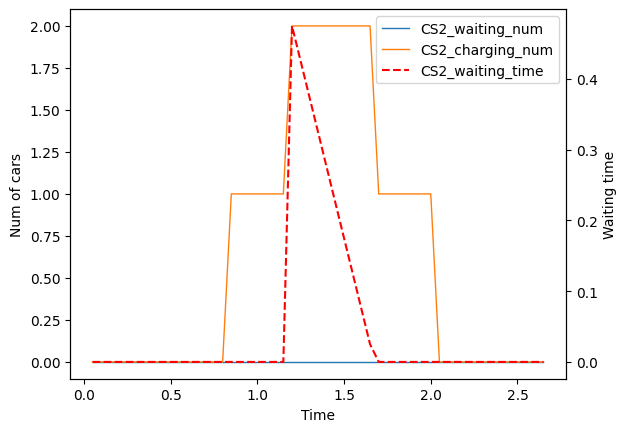

In [3]:
i = 2
columns1 = ['CS{}_waiting_num'.format(i), 'CS{}_charging_num'.format(i)]
columns2 = ['CS{}_waiting_time'.format(i)]

ax1 = plt.subplot()
l1 = ax1.plot(
    time, df_cs[columns1], label=columns1,
    linewidth=1
    )
ax1.set_ylabel('Num of cars')

ax2 = ax1.twinx()
l2 = ax2.plot(
    time, df_cs[columns2], label=columns2[0], 
    linestyle="--", c='red',
    )
ax2.set_ylabel('Waiting time')

ax1.set_xlabel('Time')
lines = l1 + l2
labs = [label.get_label() for label in lines]
# plt.grid()
plt.legend(lines, labs)

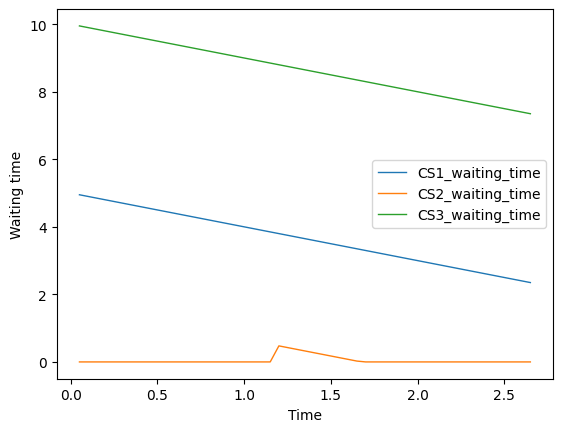

In [4]:

columns = []
for i in range(1, env.num_cs-1):
    columns.append('CS{}_waiting_time'.format(i))
plt.plot(
    time, df_cs[columns], label=columns, 
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('Waiting time')
plt.legend()

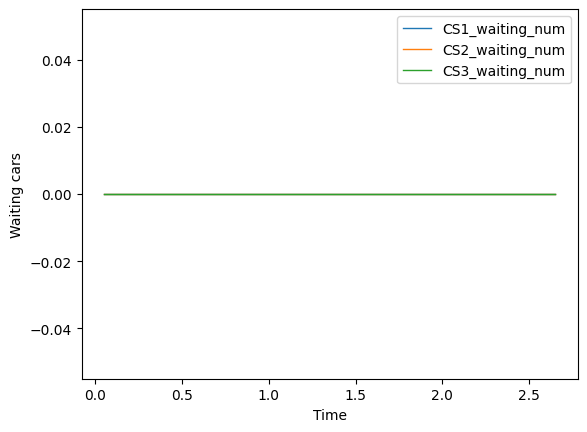

In [5]:
columns = []
for i in range(1, env.num_cs-1):
    columns.append('CS{}_waiting_num'.format(i))
plt.plot(
    time, df_cs[columns], label=columns,
    linewidth=1
    )
plt.xlabel('Time')
plt.ylabel('Waiting cars')
plt.legend()

EV

In [6]:
df_route = pd.read_csv(dir+'/Map.csv')
time = df_route['time']

OD2edge = {} # O-D: 边编号
for e in range(env.edge_index.shape[1]):
    O = int(env.edge_index[0][e])
    D = int(env.edge_index[1][e])
    index = str(O) + '-' + str(D)
    OD2edge[index] = e

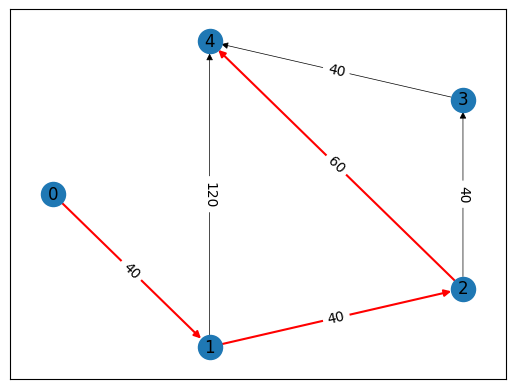

In [7]:
edge_set = copy.deepcopy(env.edge_dic)
edge_num = copy.deepcopy(env.edge_dic)
for edge in env.edge_dic.keys():
    cl = list(set(df_route[edge]))
    for c in cl:
        cc = str(c)
        if cc != 'nan':
            cc = cc.split('-')
            for i in cc:
                car_id = int(i)
                if car_id not in edge_set[edge]:
                    edge_set[edge].append(car_id)
for edge in env.edge_dic.keys():
    edge_num[edge] = len(edge_set[edge]) / agent_num

G = nx.DiGraph()
G.add_nodes_from(range(env.map_adj.shape[0]))
for i in range(env.edge_index.shape[1]):
    G.add_edge(
        env.edge_index[0][i], env.edge_index[1][i], 
        length=env.edge_attr[i][0],
        weight=edge_num[str(env.edge_index[0][i])+'-'+str(env.edge_index[1][i])]
        )
pos = nx.shell_layout(G)

edge0 = [(u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] == 0]
edge1 = [(u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] > 0]

# nodes
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
# edges
nx.draw_networkx_edges(G, pos, edgelist=edge0, width=0.5)
nx.draw_networkx_edges(G, pos, edgelist=edge1, width=[float(d['weight'] + 0.5)*1 for (u,v,d) in edge1], edge_color='r', )

nx.draw_networkx_edge_labels(G, pos=nx.shell_layout(G), edge_labels=nx.get_edge_attributes(G, 'length'))
# nx.draw_networkx_edge_labels(G, pos=nx.shell_layout(G), edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.show()

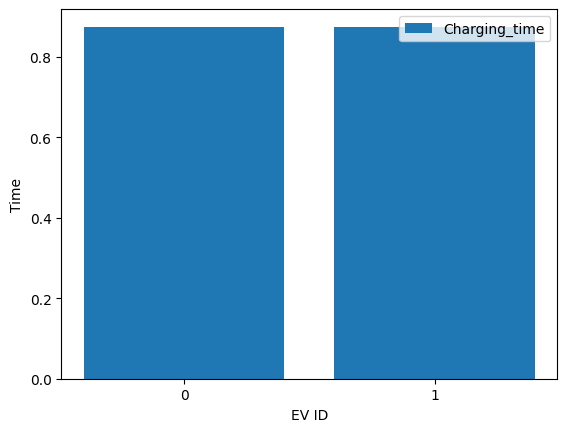

In [8]:
df_ev_g = pd.read_csv(dir+'/EV_g.csv')
ev = df_ev_g['EV']
plt.bar(
    ev, df_ev_g['Charging_time'], label='Charging_time', 
    linewidth=1
    )
plt.xticks(ev)
plt.xlabel('EV ID')
plt.ylabel('Time')
plt.legend()

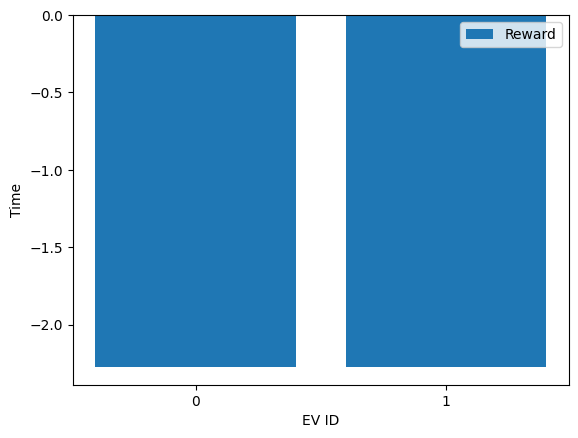

In [9]:
df_ev_g = pd.read_csv(dir+'/EV_g.csv')
ev = df_ev_g['EV']
plt.bar(
    ev, df_ev_g['Reward'], label='Reward', 
    linewidth=1
    )
plt.xticks(ev)
plt.xlabel('EV ID')
plt.ylabel('Time')
plt.legend()

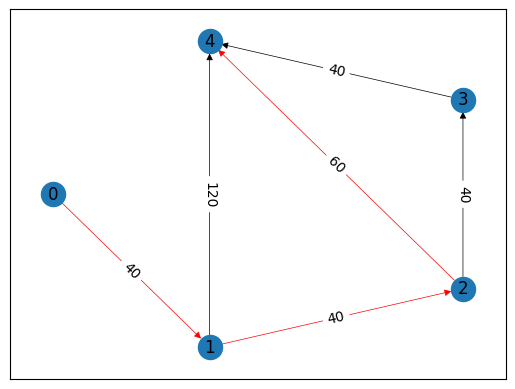

In [10]:
ev_id = 0
df_r = pd.read_csv(dir+'/EV/EV{}_route.csv'.format(ev_id))
route = list(df_r['edge'])

G = nx.DiGraph()
G.add_nodes_from(range(env.map_adj.shape[0]))
for i in range(env.edge_index.shape[1]):
    edge = str(env.edge_index[0][i])+'-'+str(env.edge_index[1][i])
    G.add_edge(
        env.edge_index[0][i], env.edge_index[1][i], 
        length=env.edge_attr[i][0],
        weight=1 if edge in route else 0
        )
pos = nx.shell_layout(G)

edge0 = [(u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] == 0]
edge1 = [(u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] == 1]

# nodes
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
# edges
nx.draw_networkx_edges(G, pos, edgelist=edge0, width=0.5)
nx.draw_networkx_edges(G, pos, edgelist=edge1, width=0.5, edge_color='r', )

nx.draw_networkx_edge_labels(G, pos=nx.shell_layout(G), edge_labels=nx.get_edge_attributes(G, 'length'))
# nx.draw_networkx_edge_labels(G, pos=nx.shell_layout(G), edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.show()

In [11]:
route_con = {}
route_list = {}
for i in range(env.agent_num):
    ev_id = i
    df_r = pd.read_csv(dir+'/EV/EV{}_route.csv'.format(ev_id))
    route = list(df_r['edge'])
    r = route[0]
    for j in range(1, len(route)):
        next_p = route[j].split('-')[-1]
        r += "-"+next_p
    if r not in route_con.keys():
        route_con[r] = 1
        route_list[r] = [ev_id]
    else:
        route_con[r] += 1
        route_list[r].append(ev_id)

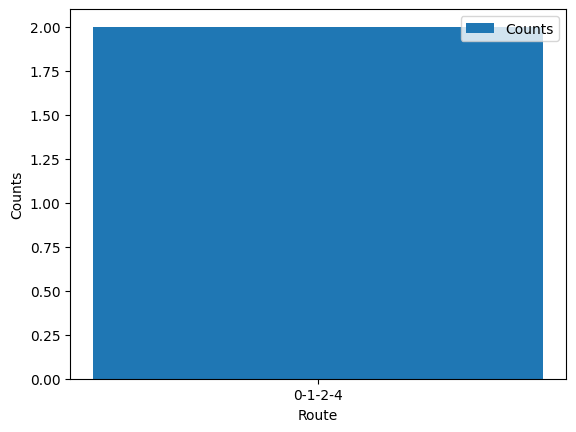

In [12]:
plt.bar(
    list(route_con.keys()), list(route_con.values()), label='Counts', 
    linewidth=1
    )
plt.xlabel('Route')
plt.ylabel('Counts')
plt.legend()

Text(0, 0.5, 'EV SOC (%)')

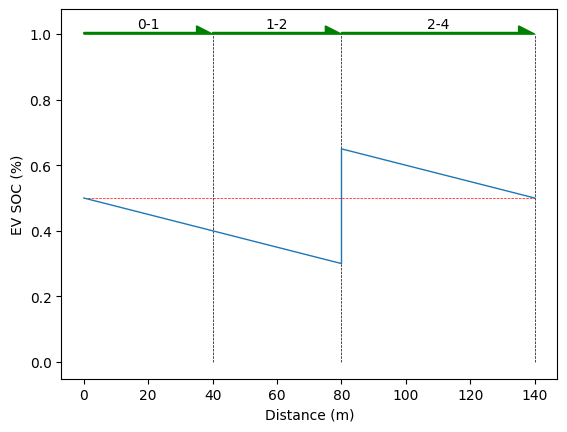

In [13]:
ev_id = 0
df_ev = pd.read_csv(dir+'/EV/EV{}.csv'.format(ev_id))
init_soc = env.agents[ev_id].SOC_init
exp_soc = env.agents[ev_id].SOC_exp
dis = [0]
soc = [init_soc]

i = 1
while i < df_ev.shape[0]:
    if df_ev.iloc[i-1]['position'] != df_ev.iloc[i]['position']:
        if 'P' in df_ev.iloc[i]['position']:
            dis.append(df_ev.iloc[i-1]['distance']) # type: ignore
            soc.append(df_ev.iloc[i-1]['SOC'])
            dis.append(df_ev.iloc[i]['distance']) # type: ignore
            soc.append(df_ev.iloc[i]['SOC'])
    i += 1
dis.append(df_ev.iloc[i-1]['distance']) # type: ignore
soc.append(df_ev.iloc[i-1]['SOC'])

df_r = pd.read_csv(dir+'/EV/EV{}_route.csv'.format(ev_id))
ev_r = list(df_r['edge'])

cs_dis = 0
for edge in ev_r:
    d = env.edge_attr[OD2edge[edge]][0]
    plt.arrow(
        cs_dis, 1, 
        d, 0, 
        width=0.01, head_width=0.05, head_length=5,
        shape='right', color='g',
        length_includes_head=True
        )
    plt.text(cs_dis+d/2, 1.01, edge, ha='center', verticalalignment='bottom')
    cs_dis += d
    plt.plot(
        [cs_dis, cs_dis], [0, 1], label='CS'+str(i),
        linestyle="--", c='black',
        linewidth=0.5
        )
    
plt.plot(
    [0, cs_dis], [exp_soc, exp_soc], label='CS'+str(i),
    linestyle="--", c='red',
    linewidth=0.5
    )

plt.plot(
    dis, soc,
    linewidth=1
    )

plt.xlabel('Distance (m)')
plt.ylabel('EV SOC (%)')

Text(0, 0.5, 'EV SOC (%)')

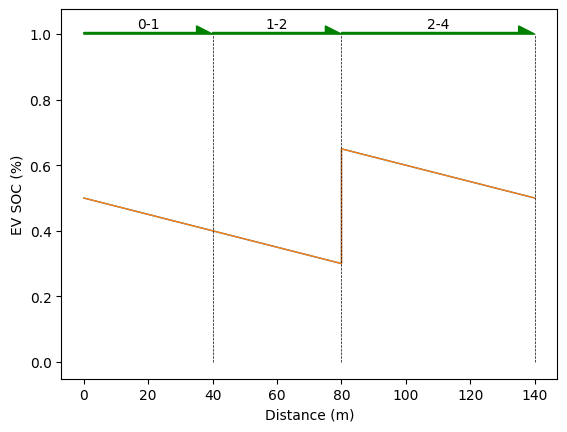

In [14]:
route = list(route_list.keys())[0]
ev_id_list = route_list[route]

for ev_id in ev_id_list:
    ev_id = 0
    df_ev = pd.read_csv(dir+'/EV/EV{}.csv'.format(ev_id))
    init_soc = env.agents[ev_id].SOC_init
    exp_soc = env.agents[ev_id].SOC_exp
    dis = [0]
    soc = [init_soc]

    i = 1
    while i < df_ev.shape[0]:
        if df_ev.iloc[i-1]['position'] != df_ev.iloc[i]['position']:
            if 'P' in df_ev.iloc[i]['position']:
                dis.append(df_ev.iloc[i-1]['distance']) # type: ignore
                soc.append(df_ev.iloc[i-1]['SOC'])
                dis.append(df_ev.iloc[i]['distance']) # type: ignore
                soc.append(df_ev.iloc[i]['SOC'])
        i += 1
    dis.append(df_ev.iloc[i-1]['distance']) # type: ignore
    soc.append(df_ev.iloc[i-1]['SOC'])
    
    plt.plot(
        dis, soc,
        linewidth=1
        )
    
route_split = route.split('-')
route_part = []
for i in range(1, len(route_split)):
    route_part.append(route_split[i-1]+"-"+route_split[i])

cs_dis = 0
for edge in route_part:
    d = env.edge_attr[OD2edge[edge]][0]
    plt.arrow(
        cs_dis, 1, 
        d, 0, 
        width=0.01, head_width=0.05, head_length=5,
        shape='right', color='g',
        length_includes_head=True
        )
    plt.text(cs_dis+d/2, 1.01, edge, ha='center', verticalalignment='bottom')
    cs_dis += d
    plt.plot(
        [cs_dis, cs_dis], [0, 1], label='CS'+str(i),
        linestyle="--", c='black',
        linewidth=0.5
        )
    
# plt.plot(
#     [0, cs_dis], [exp_soc, exp_soc], label='CS'+str(i),
#     linestyle="--", c='red',
#     linewidth=0.5
#     )

plt.xlabel('Distance (m)')
plt.ylabel('EV SOC (%)')